In order to install CAMB you can do `conda install pycamb -c conda-forge`

The alternative is `pip install pycamb` -> This one may entail installing `gfortran` and linking to the newer `gfortran` version.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import camb
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import camb.correlations
from camb import model, initialpower
import numpy as np
import astropy.table
import pandas as pd
import pickle
from astroML.datasets import fetch_sdss_specgals

In [2]:
data = fetch_sdss_specgals()
m_max = 17.7
# redshift and magnitude cuts
data = data[data['z'] > 0.08]
data = data[data['z'] < 0.12]
data = data[data['petroMag_r'] < m_max]
# RA/DEC cuts
RAmin, RAmax = 140, 220 
DECmin, DECmax = 5, 45
data = data[data['ra'] < RAmax] 
data = data[data['ra'] > RAmin] 
data = data[data['dec'] < DECmax] 
data = data[data['dec'] > DECmin]
ur = data['modelMag_u'] - data['modelMag_r'] 
flag_red = (ur > 2.22)
flag_blue = ~flag_red
data_red = data[flag_red] 
data_blue = data[flag_blue]
print("data size:")
print(" red gals: ", len(data_red)) 
print(" blue gals:", len(data_blue))

data size:
 red gals:  38017
 blue gals: 16883


In [3]:
cut1 = pd.cut(data['z'], bins = 25)
Nz = cut1.value_counts().tolist()

keys1 = cut1.value_counts().keys()

z = []
for i in range(len(keys1)):
    z.append(keys1[i].mid)

In [4]:
#plt.hist(data['z'], bins = 100)

Nz, be = np.histogram(data['z'][flag_red], bins=8, range=(0.05,0.15))

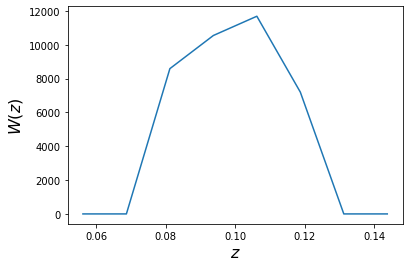

In [5]:
lmax=30000 # Maximum multipole for the power spectrum
pars = camb.CAMBparams() # Set up the CAMB parameters
h=0.675 # Planck value for h (Hubble parameter)
Ob = 0.044 # Planck value for Omega_b (Baryon energy density)
Om = 0.31 # Planck value for Omega_m (Matter energy density)
Oc = Om-Ob # Value for Omega_c (Cold dark matter energy density)
As=2e-9 # Amplitude of initial fluctuations
ns=0.965 # Scalar index
pars.set_cosmology(H0=100*h, ombh2=Ob*h**2, omch2=Oc*h**2) # This sets the cosmological parameters
pars.InitPower.set_params(As=As, ns=ns) # This also sets the cosmological parameters
pars.set_for_lmax(lmax, lens_potential_accuracy=1) # Set the maximum ell
#set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = False # We don't want the CMB
#NonLinear_both or NonLinear_lens will use non-linear corrections
pars.NonLinear = model.NonLinear_both # We want non-linear corrections
#Set up W(z) window functions, later labelled W1, W2.
zs = 0.5*(be[1:] + be[:-1]) #z # Range of zs
W = Nz # Window function
plt.plot(zs, W)
plt.xlabel('$z$', fontsize=16)
plt.ylabel('$W(z)$', fontsize=16)
pars.SourceWindows = [SplinedSourceWindow(source_type='counts', bias=1.0, z=zs, W=W)] # Set up the window function

In [6]:
%%time
results = camb.get_results(pars)
cls = results.get_source_cls_dict()
ls=  np.arange(2, lmax+1)

CPU times: user 2min 57s, sys: 765 ms, total: 2min 58s
Wall time: 48.9 s


CAMB returns the power spectrum for as many windows as we define. Note that it returns the power spectrum as:

$$C_{\ell}\ell(\ell+1)/2\pi$$

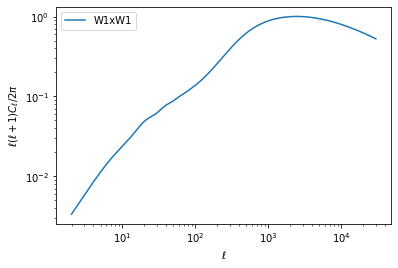

In [7]:
for spectrum in ['W1xW1']:
    plt.loglog(ls, cls[spectrum][2:lmax+1], label=spectrum)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')
plt.legend();

Now that we have the angular power spectrum we want to compute the correlation function. CAMB also has a way to compute the correlation function from the angular power spectrum:

In [8]:
angles = np.logspace(-2, 1) # Angles from 0.01 to 10 deg
x = np.cos(np.radians(angles)) # Convert them to radians and compute cosine to passs to CAMB
cls_in = np.array([cls['W1xW1'][1:lmax+1], np.zeros(lmax), np.zeros(lmax), np.zeros(lmax)]).T
#cl2corr needs TT (temperature/density), EE (E-mode), BB (B-mode), TE (Temperature-polarization cross correlation) -> we only care about TT
w_camb = camb.correlations.cl2corr(cls_in, x);

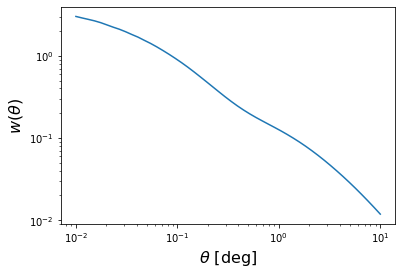

In [9]:
plt.loglog(angles, w_camb[:,0])
plt.xlabel(r'$\theta$ [deg]', fontsize=16)
plt.ylabel(r'$w(\theta)$', fontsize=16);

In [10]:
with open('camb_theta2', 'wb') as filehandle:
    pickle.dump(angles, filehandle)
    
with open('camb_w2', 'wb') as filehandle:
    pickle.dump(w_camb[:,0], filehandle)